1. retrieve 
2. generate
3. rewrite <- 신규 노드
4. 문서 검증 <- 신규 노드 

In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)
retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [2]:
from langgraph.graph import StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

노드 만들기

In [3]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

프롬프트가 rewrite 등 여러군데에서 쓰이므로 이름 별도 지정 

In [5]:
from langchain_classic import hub

generate_prompt = hub.pull("rlm/rag-prompt")

In [15]:
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'question':query, 'context': context})
    return {'answer': response}

문서의 관련성을 측정하는 노드 만들기 

In [7]:
from langchain_classic import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']
    context = state['context']
    print(f'context == {context}')
    doc_relevance_chain = doc_relevance_prompt | llm
    response =  doc_relevance_chain.invoke({'question':query, 'documents': context})
    print(f'doc relevance reponse: {response}')
    if response['Score'] == 1:
        return 'generate'
    return 'rewrite'

rewrite 작성하기 

In [8]:
query = '연봉 5천만원 직장인의 소득세는?'

In [9]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전 : {dictionary}
질문 : {query}
""")
 
def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    reponse = rewrite_chain.invoke({'query': query})
    return {'query' : reponse}

In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

엣지 추가하기 

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

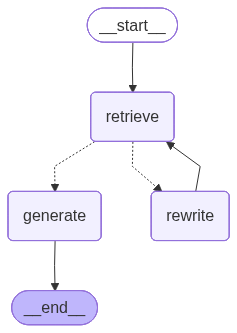

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

context == [Document(id='8125a242-087b-4e4b-8d90-31f925d202f9', metadata={'source': './documents/income_tax.md'}, page_content='소득세법\n\n소득(이하 이 조에서 “임용근로소득”이라 한다)에 대한 지급명세서의 경우에는 제출하지 아니한 본인 지급금액의 1만분의 25(제출기한이 지난 후 1개월 이내에 제출하는 경우에는 지급금액의 10만분의 12.5)로 한다. 나. 간이지급명세서의 경우: 제출하지 아니한 본인 지급금액의 1만분의 20(제출기한이 지난 후 1개월 이내에 제출하는 경우에는 지급금액의 10만분의 12.5로 한다).\n\n제출된 지급명세서 등이 대통령령으로 정하는 불분명한 경우에 해당하거나 제출된 지급명세서에 기재된 지급금액이 사실과 다른 경우: 다음 각 목의 구분에 따른 금액 가. 지급명세서의 경우: 불분명하거나 사실과 다른 본인 지급금액의 100분의 1. 다만, 임용근로소득에 대한 지급명세서의 경우에는 불분명하거나 사실과 다른 본인 지급금액의 1만분의 25로 한다. 나. 간이지급명세서의 경우: 불분명하거나 사실과 다른 본인 지급금액의 1만분의 25'), Document(id='a9912fc1-b001-4ff6-9b64-349b76dd0a83', metadata={'source': './documents/income_tax.md'}, page_content='제2장 거주자의 종합소득 및 퇴직소득에 대한 납세의무 <개정 2009. 12. 31.> 제1절 비과세 <개정 2009. 12. 31.>\n\n소득세법\n\n제12조(비과세소득) 다음 각 호의 소득에 대해서는 소득세를 과세하지 아니한다. <개정 2010. 12. 27., 2011. 7. 25., 2011. 9. 15., 2012. 2. 1., 2013. 1. 1., 2013. 3. 22., 2014. 1. 1., 2014. 3. 18., 2014. 12. 23., 2015. 12. 15., 2016. 

{'query': '거주자의 연봉 5천만원 소득세는 얼마인가요?',
 'context': [Document(id='32bc2bde-8308-4b99-b9ea-86a1e517cf66', metadata={'source': './documents/income_tax.md'}, page_content='제49조 삭제 <2006. 12. 30.>\n\n법제처 30 국가법령정보센터\n\n소득세법\n\n제6관 종합소득공제 <개정 2009. 12. 31.>\n\n제50조(기본공제) ① 종합소득이 있는 거주자(자연인만 해당한다)에 대해서는 다음 각 호의 어느 하나에 해당하는 사람의 수에 1명당 연 150만원을 곱하여 계산한 금액을 그 거주자의 해당 과세기간의 종합소득금액에서 공제한다. <개정 2015. 12. 15., 2024. 12. 31.> 1. 해당 거주자 2. 거주자의 배우자로서 해당 과세기간의 소득금액이 없거나 해당 과세기간의 소득금액 합계액이 100만원 이하인 사람(종금액이 500만원 이하의 근로소득만 있는 배우자를 포함한다) 3. 거주자와 배우자를 포함한다. 이하 이 호에서 같거나 생계를 같이 하는 다음 각 목의 어느 하나에 해당하는 부양자들(제15조제1항제2호의 장애인에 해당되는 경우에는 나이의 제한을 받지 아니한다고로서 해당 과세기간의 소득금액 합계액이 100만원 이하인 사람(종금액이 500만원 이하의 근로소득만 있는 부양자를 포함한다) 가. 거주자의 직계존속(직계존속이 재혼한 경우에는 그 배우자로서 대통령령으로 정하는 사람을 포함한다)으로서 60세 이상인 사람 나. 거주자의 직계비속으로서 대통령령으로 정하는 사람과 대통령령으로 정하는 동거 입양자(이하 “입양자”라 한다)로서 20세 이하(20세가 되는 날과 그 이전 기간을 말한다. 이하 이 조에서 같다)인 사람. 이 경우 해당 직계비속 또는 입양자와 그 배우자가 모두 제15조제1항제2호에 따른 장애인에 해당하는 경우에는 그 배우자를 포함한다. 다. 거주자의 형제자매로서 20세 이하 또는 60세 이상인 사람 